In [40]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from PIL import Image
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [41]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [42]:
# Download and load training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load test data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Showing how the data looks in the CIFAR-10 dataset.
We added the names of the first row

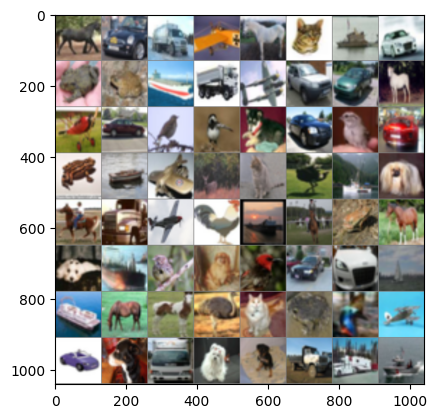

horse car   truck plane horse cat   ship  car  


In [43]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()  # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose for (H, W, C)
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)


imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[i]]:5s}' for i in range(8)))

In [44]:
target_class = 3  # 'cat'

# Convert CIFAR-10 dataset labels to binary: 1 = cat, 0 = not cat
def convert_to_binary(dataset, target_class=3):  # Default to 'cat' class (3)
    dataset.targets = [1 if label == target_class else 0 for label in dataset.targets]
    return dataset

# Apply conversion to binary classification for both train and test sets
trainset = convert_to_binary(trainset)
testset = convert_to_binary(testset)

# Use subset to make it faster (50000 train, 10000 test)
train_subset = Subset(trainset, range(50000))
test_subset = Subset(testset, range(10000))

# DataLoaders
trainLoader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

In [45]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

In [46]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in trainLoader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Epoch 1, Loss: 157.2756
Epoch 2, Loss: 117.8602
Epoch 3, Loss: 95.5405
Epoch 4, Loss: 77.0180
Epoch 5, Loss: 60.1630
Epoch 6, Loss: 47.8375
Epoch 7, Loss: 36.2725
Epoch 8, Loss: 28.4359
Epoch 9, Loss: 23.7644
Epoch 10, Loss: 18.5308


In [47]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5  # Convert logits to probability, then threshold
        correct += (preds.squeeze().long() == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 95.14%


Prediction: Cat (confidence: 0.87)


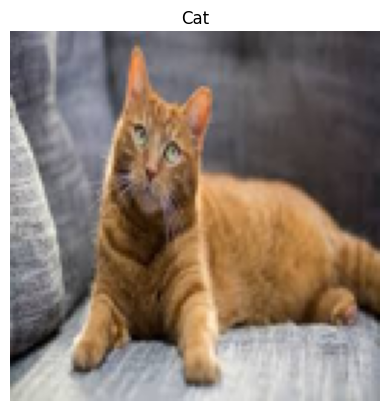

Prediction: Not Cat (confidence: 0.00)


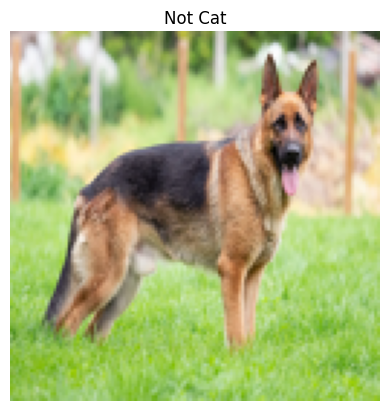

In [58]:
# Make sure we have the right transformations for prediction
predict_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Match CIFAR-10 image size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Match training normalization
])

def predict_image(img_path, model):
    model.eval()  # Set model to evaluation mode
    img = Image.open(img_path).convert('RGB')  # Open image
    img_tensor = predict_transform(img).unsqueeze(0).to(device)  # Apply transformations and move to device

    with torch.no_grad():
        output = model(img_tensor)  # Pass img_tensor to the model
        prob = torch.sigmoid(output).item()  # Apply sigmoid to get probability

    # Threshold for binary classification: 0.5 for cat vs not-cat
    result = "Cat" if prob > 0.5 else "Not Cat"
    print(f"Prediction: {result} (confidence: {prob:.2f})")

    # Show image with result title
    plt.imshow(img.resize((128, 128)))  # Resize to show what the model sees
    plt.title(result)
    plt.axis('off')
    plt.show()

# Finally, run:
predict_image("cat_image.jpg", model)
predict_image("dog_image.jpg", model)
